In [1]:
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 4
BATCH_SIZE = 8
EVENT_SPLIT_METHOD = 'temporal'
COMPONENT_ORDER = 'ZNE'
DIMENSION_ORDER = 'NCW'

In [3]:
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=NUM_CLASSES,
  batch_size=BATCH_SIZE,
  event_split_method=EVENT_SPLIT_METHOD,
  component_order=COMPONENT_ORDER,
  standardize=True,
)


Seed set to 42
Seed set to 42


In [4]:
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import ShockClassifierLit #Wav2Vec2ForSequenceClassification

def get_seisLM_config():

  config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/foreshock_aftershock/seisLM_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)

  config.model_args.num_classes = NUM_CLASSES
  config.model_args.use_weighted_layer_sum = True
  return config

seisLM_config = get_seisLM_config()

models = {}

models['seisLM'] = ShockClassifierLit(
  model_name='Wav2Vec2ForSequenceClassification',
  model_config=seisLM_config.model_args,
  training_config=seisLM_config.trainer_args,
  ).model



In [5]:
def get_conv1d_config():
  config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/foreshock_aftershock/conv1d_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)
  config.model_args.num_classes = NUM_CLASSES
  return config

conv1d_config = get_conv1d_config()

models['cnn'] = ShockClassifierLit(
  model_name='Conv1DShockClassifier',
  model_config=conv1d_config.model_args,
  training_config=conv1d_config.trainer_args,
  ).model

In [6]:
waveforms, labels = next(iter(loaders['train']))


key = 'cnn'
# key = 'seisLM'
model = models[key]


logits = models[key](waveforms)
loss = torch.nn.functional.cross_entropy(logits, labels)
predicted_labels = torch.argmax(logits, 1)

print(loss)

tensor(1.4608, grad_fn=<NllLossBackward0>)


In [20]:
models['seisLM'].config

Wav2Vec2Config {
  "activation_dropout": 0.0,
  "adapter_attn_dim": null,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForPreTraining"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "classifier_dropout": 0.2,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    256,
    256
  ],
  "conv_kernel": [
    3,
    3
  ],
  "conv_stride": [
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "layer",
  "feat_proj_dropout": 0.0,
  "feat_quantizer_dropout": 0.0,
  "final_dropout": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 240,
  "initializer_range": 0.0

In [7]:

# for key, model in models.items():

# key = 'cnn'
key = 'seisLM'
model = models[key]


logits = models[key](waveforms)
loss = torch.nn.functional.cross_entropy(logits, labels)
predicted_labels = torch.argmax(logits, 1)


Text(0.5, 1.0, 'Wav2Vec2 last hidden states')

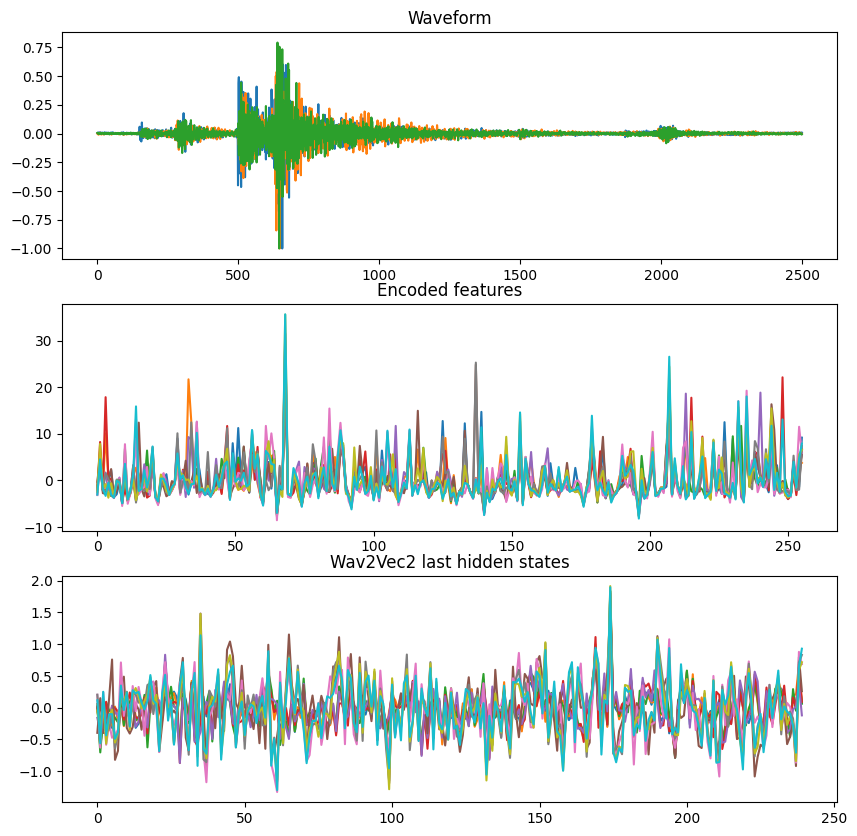

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
sample_idx = 0
num_channels_to_display = 10

with torch.no_grad():
  wav2vec2_outputs = model.wav2vec2(waveforms)

axes[0].plot(waveforms[0].T)
axes[0].set_title('Waveform')

axes[1].plot(wav2vec2_outputs.extract_features[0][:num_channels_to_display, :].detach().numpy().T)
axes[1].set_title('Encoded features')

axes[2].plot(wav2vec2_outputs.last_hidden_state[0][:num_channels_to_display, :].detach().numpy().T)
axes[2].set_title('Wav2Vec2 last hidden states')


In [9]:
wav2vec2_outputs.extract_features.detach().numpy()[0]

array([[-2.0275855 ,  3.7321427 , -2.2695374 , ..., -2.1449535 ,
        -1.4009508 ,  9.1911335 ],
       [-1.2674514 ,  6.5220466 , -1.9944692 , ..., -1.8012836 ,
         3.2393503 ,  3.775301  ],
       [-2.0670214 ,  4.5846715 , -1.9562824 , ...,  0.8612713 ,
         3.9960377 ,  6.633955  ],
       ...,
       [ 2.168733  ,  5.383209  , -2.3914084 , ...,  2.8205833 ,
         8.600794  ,  6.987413  ],
       [-1.7391374 ,  3.262831  , -1.5972517 , ...,  0.9260145 ,
        -0.33009642,  5.1420293 ],
       [-0.3721948 ,  1.5962691 , -2.5902805 , ..., -2.2407603 ,
        -0.04184412,  5.258559  ]], dtype=float32)

In [10]:
wav2vec2_outputs.last_hidden_state.shape

torch.Size([8, 624, 240])

In [19]:
seisLM_config

data_args:
  batch_size: 64
  component_order: ZNE
  dimension_order: NCW
  event_split_method: temporal
  num_workers: 8
  remove_class_overlapping_dates: false
  seed: 42
  standardize: true
  test_frac: 0.2
  train_frac: 0.7
  val_frac: 0.1
model_args:
  classifier_dropout: 0.2
  classifier_proj_size: 256
  learning_rate: 0.001
  num_classes: 4
  pretrained_ckpt_path: /scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-07-14-20h-19m-28s/checkpoints/epoch=37-step=998944.ckpt
  use_weighted_layer_sum: true
  weight_decay: 0.1
model_name: Wav2Vec2ForSequenceClassification
trainer_args:
  accelerator: gpu
  devices: 2
  max_epochs: 15
  strategy: ddp
  unfreeze_base_at_epoch: 0
  warmup_frac_step: 0.0

In [12]:
import numpy as np
u, s, vh = np.linalg.svd(wav2vec2_outputs.last_hidden_state[0])

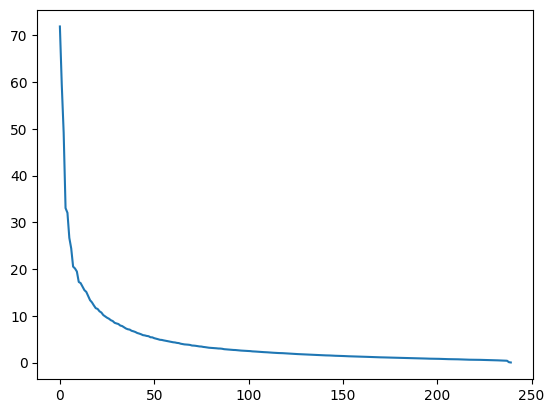

In [13]:
plt.plot(s)

In [14]:
seisLM_config

data_args:
  batch_size: 64
  component_order: ZNE
  dimension_order: NCW
  event_split_method: temporal
  num_workers: 8
  remove_class_overlapping_dates: false
  seed: 42
  standardize: true
  test_frac: 0.2
  train_frac: 0.7
  val_frac: 0.1
model_args:
  classifier_dropout: 0.2
  classifier_proj_size: 256
  learning_rate: 0.001
  num_classes: 4
  pretrained_ckpt_path: /scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-07-14-20h-19m-28s/checkpoints/epoch=37-step=998944.ckpt
  use_weighted_layer_sum: true
  weight_decay: 0.1
model_name: Wav2Vec2ForSequenceClassification
trainer_args:
  accelerator: gpu
  devices: 2
  max_epochs: 15
  strategy: ddp
  unfreeze_base_at_epoch: 0
  warmup_frac_step: 0.0

In [15]:
torch.nn.functional.softmax(models['seisLM'].layer_weights)




/tmp/ipykernel_26136/602353954.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(models['seisLM'].layer_weights)


tensor([0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
       grad_fn=<SoftmaxBackward0>)

In [16]:
import torch

from torch import nn



m = nn.Dropout1d(p=0.5)
input = torch.randn(1, 16, 240)

output = m(input)
output


tensor([[[ 1.6415, -2.8133, -0.0606,  ..., -2.6753,  3.1623,  0.7857],
         [ 0.8337, -0.0792, -0.5851,  ..., -0.5799, -1.7651, -0.7495],
         [-0.1900, -2.3046,  1.1386,  ..., -0.4043,  1.0448,  4.5517],
         ...,
         [ 1.8158,  2.2925, -0.4921,  ..., -0.8868,  1.1462,  3.2948],
         [ 0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000,  0.0000]]])

In [17]:
output[0][-2].shape


torch.Size([240])

In [18]:
output

tensor([[[ 1.6415, -2.8133, -0.0606,  ..., -2.6753,  3.1623,  0.7857],
         [ 0.8337, -0.0792, -0.5851,  ..., -0.5799, -1.7651, -0.7495],
         [-0.1900, -2.3046,  1.1386,  ..., -0.4043,  1.0448,  4.5517],
         ...,
         [ 1.8158,  2.2925, -0.4921,  ..., -0.8868,  1.1462,  3.2948],
         [ 0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000,  0.0000]]])